In [169]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
from joblib import Parallel, delayed

#### Simple Demonstration of Online Learning

In [165]:
def online_sample_from_task(d=2):
    mu = np.array([1, 1])
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task(n, d=2):
    mu = np.array([1, 1])
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [166]:
T = 500
n_test = 500

w = np.array([1, 0]) # initialize
X, Y = batch_sample_from_task(n_test)
error = []
for t in range(1, T):
    x, y = online_sample_from_task()
    lr = 0.01
    w = w + lr * x * y
    w = w / np.linalg.norm(w)
    
    Y_hat = np.sign(X @ w)
    error.append(np.mean(Y != Y_hat))

Text(0.5, 0, 'Time')

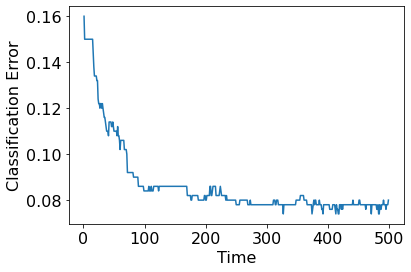

In [170]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 500), error)
ax.set_ylabel("Classification Error")
ax.set_xlabel("Time")

#### Online Learning vs Alternating Task Sequence

In [171]:
def online_sample_from_task_sequence(t, N=20, d=2):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, 1])    
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task_sequence(n, t, N=20, d=2, seed=1996):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, 1])
    # np.random.seed(seed)    
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [172]:
N = 500
T = 2000
n_test = 1000

w = np.array([1, 0]) # initialize
error = []
for t in range(1, T):
    x, y = online_sample_from_task_sequence(t, N)
    lr = 0.01
    w = w + lr * x * y
    w = w / np.linalg.norm(w)
    
    X_test, Y_test = batch_sample_from_task_sequence(n_test, t, N)
    Y_hat = np.sign(X_test @ w)
    error.append(np.mean(Y_test != Y_hat))

(-98.9, 2098.9, -0.01, 0.1)

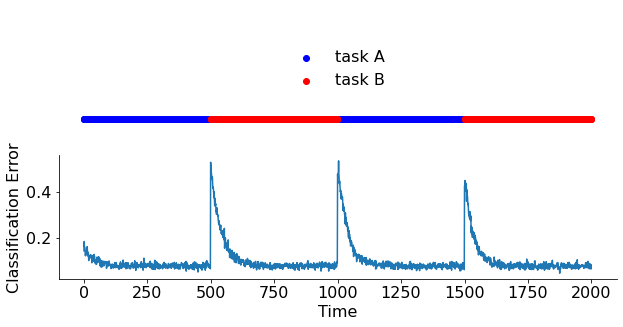

In [194]:
fig, axes = plt.subplots(2, 1, figsize=(10,5))
ax = axes[1]
ax.plot(np.arange(1, T), error)
ax.set_ylabel("Classification Error")
ax.set_xlabel("Time")
ax.spines[['right', 'top']].set_visible(False)

ax = axes[0]
taskA, taskB = [], []
for t in range(1, T):
    if (t // N) % 2 == 0:
        taskA.append(t)
    else:
        taskB.append(t)
ax.scatter(taskA, np.zeros(len(taskA)), c='b')
ax.scatter(taskB, np.zeros(len(taskB)), c='r')
ax.set_ylim([-0.01, 0.1])
ax.legend(["task A", "task B"], loc=10, frameon=False)
ax.axis('off')